In [ ]:
# Imports básicos
import numpy as np
from numpy import random
import pandas as pd
import math
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')
random.RandomState(1)

# Imports scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics import accuracy_score

# Imports pytroch
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision
from torchvision import datasets
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image as Pil_Image

# Imports para plots
import matplotlib.pyplot as plt
%matplotlib inline

<img src="https://www.ifsc.edu.br/image/layout_set_logo?img_id=1319584&t=1602803233260" width="20%">

<center>

---
# **Introdução a Redes Neurais para Classificação**
## Implementação em Python com Pytorch (Parte 3)
## <u>Prof. Carlos Andres Ferrero</u>
## Instituto Federal de Santa Catarina (IFSC), Câmpus Lages
## Grupo de Pesquisa em Análise Inteligente de Dados (IDA-IFSC)
## *Semana Nacional de Ciência e Tecnologia (SNCT/IFSC)*
---
</center>

# Aplicações em Classificação de Imagens

- Construir Redes Neurais para dados que envolvam Imagens é uma das aplicações mais comuns nos dias atuais
- Essa análise envolve geralmente os tipos de camada:
  - Convolutional Layers
  - MaxPool Layers
  - Dropout Layer
  - Dense Layers
- Quando uma rede neural tem várias camadas é chamada de **Deep Neural Network** e o aprendizado chamado de **Deep Learning**.

# Problema de Classificação de Imagens

Neste contexto de pandemia do Covid-19 é de interesse de gestores de estabelecimentos públicos e privados o controle das pessoas que entram e saem dos mesmos, em relação ao uso de máscaras.

O **objetivo** consiste em construir uma rede neural que seja capaz de **classificar imagens de pessoas** nas classes **com máscara** e **sem máscara**.

# 0 - Entender o Problema de Classificação e os Dados Disponíveis

## Baixando e carregando o conjunto de dados

Os dados foram extraídos do seguinte conjunto de dados na plataforma Kaggle: https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset

Esses dados foram baixados e posicionados em um link do Dropbox para facilitar baixar e utilizar as imagens.


In [ ]:
# Criar pasta para armazenar os dados
!mkdir -p covid-face-mask-detection-dataset
# Baixar e descompactar dados de treino
!wget -q https://www.dropbox.com/s/tvc6os8fvwxifed/Train.zip -O covid-face-mask-detection-dataset/Train.zip
!unzip -o -q covid-face-mask-detection-dataset/Train.zip -d covid-face-mask-detection-dataset/
# Baixar e descompactar dados de teste
!wget -q https://www.dropbox.com/s/r6xoz38nszc6f5k/Test.zip -O covid-face-mask-detection-dataset/Test.zip
!unzip -o -q covid-face-mask-detection-dataset/Test.zip -d covid-face-mask-detection-dataset/

**Transformadores de Imagem** são usados para transformar conjuntos de dados de imagem de forma padronizada. Essas transformações também podem usar informações aleatórias para inserir variabilidade durante a etapa treinamento do modelo (não usaremos isso nesta oportunidade).

In [ ]:
height = 32
width = 32
transform = transforms.Compose([                                
                                transforms.Resize((height,width)), # Redimensionar para 32x32 pixels
                                transforms.ToTensor() # Transformar para o formato adequado de análise
                                ])

train_data=datasets.ImageFolder('covid-face-mask-detection-dataset/Train', transform=transform)
test_data=datasets.ImageFolder('covid-face-mask-detection-dataset/Test', transform=transform)

**Data Loaders** são usados para obter subconjuntos de imagens tamanho pré-definido (*batch_size*) escolhidos aleatoriamente.

In [ ]:
batch_size = 16
train_loader = data_utils.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = data_utils.DataLoader(test_data, batch_size=batch_size, shuffle=False)

**Iteradores** são usados para acessar subconjuntos de imagens de *Data Loaders*

In [ ]:
train_iter = iter(train_loader)

In [ ]:
images, labels = next(train_iter)
print('Shape de images:', images.shape)
print('Shape de labels:', labels.shape)

Shape de images: torch.Size([16, 3, 32, 32])
Shape de labels: torch.Size([16])


No shape de images o primeiro valor indica o número de imagens do subconjunto (batch), o segundo valor o número de canais (1 em GrayScale e 3 em RGB, por exemplo) e os últimos dois valores são as dimensões da imagem.

No shape de labels o valor indica o número de labels, um para cada imagem.

**Mostrar uma imagem**

Ao mostrar uma imagem usando a biblioteca *matplotlib* temos que transformar as dimensões da imagem, posicionando o número de canais como a última dimensão, por ex., de \[3, 32, 32\] para \[32, 32, 3\].

Classes:
- Classe 0 - Com máscara
- Classe 1 - Sem máscara

In [ ]:
# TODO - Criar um dicionário para significado das classes
label_desc = {0 : 'com máscara', 1 : 'sem máscara'}

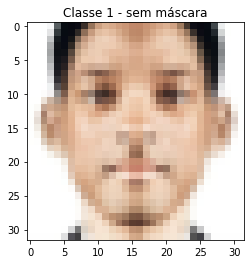

In [ ]:
i = 0
plt.imshow(images[i].permute(1, 2, 0).squeeze())
plt.title('Classe %i - %s' % (labels[i], label_desc[ labels.detach().numpy()[i] ] ))
plt.show()

**Mostrar várias imagens**

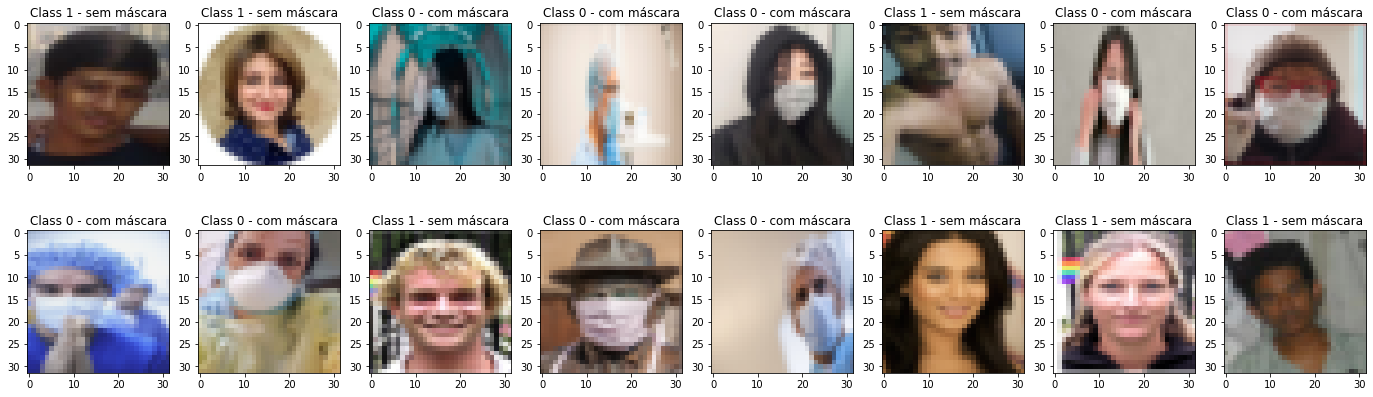

In [ ]:
fig = plt.figure(figsize=(24, 7))
rows = 2
columns = math.ceil(batch_size / rows)

for i in range(0, columns*rows):
    img = images[i].permute(1, 2, 0).squeeze()
    fig.add_subplot(rows, columns, i+1, title = 'Classe %i - %s' % (labels[i], label_desc[ labels.detach().numpy()[i] ] ) )
    plt.imshow(img)

# 1 - Definição de Arquitetura

**Representação Visual**

<div align="center">
<img  src="https://raw.githubusercontent.com/anfer86/teaching-datascience-lessons/master/aula08/img/cnn_model.svg">
</div>

- [Link GIF Convolution](https://miro.medium.com/max/494/1*nYf_cUIHFEWU1JXGwnz-Ig.gif)
- [Link GIF MaxPool](https://developers.google.com/machine-learning/practica/image-classification/images/maxpool_animation.gif)

**Implementação da Rede Neural**

In [55]:
class Network_Mask_Detection_CNN(nn.Module):
    def __init__(self):
        super().__init__()        
        # convolutional layer (imagem de 32x32x3) 
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        # convolutional layer (para 16x16x16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # convolutional layer (para 8x8x32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # linear layer (64 * 4 * 4 = 1024 para 16)
        self.fc1 = nn.Linear(64 * 4 * 4, 16)
        # linear layer (16 para 1)
        self.fc2 = nn.Linear(16, 1)
        # maxPooling para reduzir à metade cada imagem 
        self.pool = nn.MaxPool2d(2, 2)
        # dropout layer
        self.dropout = nn.Dropout(0.25)
        
        
    def forward(self, x):
        # Extração de Features usando Convolutional Layers e Maxpool
        x = F.relu(self.conv1(x))
        x = self.pool(x)        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        # Transformar 64x4x4 para 1x1024
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)
        # Dense Layers para Classificação
        # De 1024 para 16
        x = F.relu(self.fc1(x))        
        x = self.dropout(x)        
        # De 16 para 1, com ativação sigmoidal para retorar
        # Um valor entre 0 e 1
        x = torch.sigmoid(self.fc2(x))
        return x 

**Resumo da Rede Neural**

In [56]:
model = Network_Mask_Detection_CNN()
from torchsummary import summary
summary(model, (3, height, width))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
           Dropout-7                 [-1, 1024]               0
            Linear-8                   [-1, 16]          16,400
           Dropout-9                   [-1, 16]               0
           Linear-10                    [-1, 1]              17
Total params: 40,001
Trainable params: 40,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.28
Params size (MB): 0.15
Estimated Tot

# 2 - Treinamento / Avaliação

In [ ]:
def train_epoch(model, trainLoader, optimizer, criterion):
    model.train()
    losses = []
    for X, y in trainLoader:
        y = y.type(torch.FloatTensor)
        optimizer.zero_grad()
        # (1) Passar os dados pela rede neural (forward)
        y_pred = model(X)              
        # (2) Calcular o erro da saída da rede com a classe das instâncias (loss)            
        loss = criterion(y_pred, y)        
        # (3) Usar o erro para calcular quanto cada peso (wi) contribuiu com esse erro (backward)
        loss.backward()
        # (4) Ataulizar os pesos da rede neural
        optimizer.step()        
        losses.append(loss.item())
        
    model.eval()
    return losses

def eval_model(model, loader):
    measures = []
    total = 0
    correct = 0
    for images, labels in loader:        
        y_pred = model(images).detach().numpy().round(0)        
        total += labels.size(0)
        correct += sum(y_pred == np.array(labels.unsqueeze(1).detach().numpy()))[0]        
    measures = {'acc' : correct/total}
    return measures

def train_and_evaluate(model, num_epochs, train_loader, test_loader):
  criterion = nn.BCELoss()  
  optimizer = optim.Adadelta(model.parameters())
  e_measures = []
  pbar = tqdm(range(num_epochs))
  for e in pbar:
      losses =  train_epoch(model, train_loader, optimizer, criterion)
      measures_on_train = eval_model(model, train_loader)
      measures_on_test  = eval_model(model, test_loader )
      train_loss = np.mean(losses)
      measures = {'epoch': e, 'train_loss': train_loss, 'train_acc' : measures_on_train['acc'].round(2), 'test_acc' : measures_on_test['acc'].round(2) }   
      pbar.set_postfix(measures)     
      e_measures += [measures]
  return pd.DataFrame(e_measures)   

In [ ]:
# TODO - Criar uma Rede Neural Network_Mask_Detection_CNN
model = Network_Mask_Detection_CNN()
# TODO - Definir o número de epocas de treinamento
num_epochs = 20
# TODO - Executar o treinamento da rede neural
train_and_evaluate(model, num_epochs, train_loader, test_loader)  

,epoch,train_loss,train_acc,test_acc
0,0,0.689713,0.57,0.50
1,1,0.656118,0.58,0.53
2,2,0.536620,0.83,0.70
3,3,0.448665,0.83,0.78
4,4,0.399437,0.88,0.81
5,5,0.311354,0.91,0.86
6,6,0.318539,0.92,0.89
7,7,0.291180,0.92,0.88
8,8,0.262159,0.91,0.85
9,9,0.251233,0.94,0.90


# 3 - Avaliação: com Dados Reais

## Captura de Imagem da Webcam

Usar o Snippet do Google Colab para captura de imagem

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


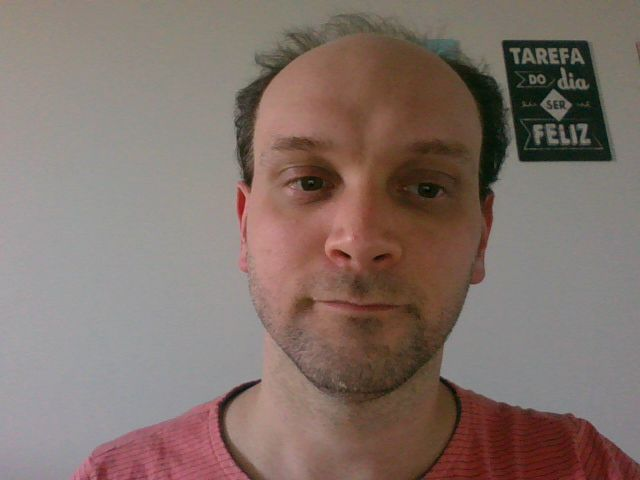

Saída da rede neural: 0.7952889
Class 1 - sem máscara


In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  img = Image(filename)
  display(img)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# TODO - Abrir a imagem salva e redimensionar
image = Pil_Image.open(filename).resize((height,width))

# TODO - Tranformar a imagem para o formato da rede
x = TF.to_tensor(image).unsqueeze_(0)

# TODO - Executar o modelo treinado
y_pred = model(x).detach().numpy().squeeze()
y_pred_class = np.round(y_pred)
y_pred_class_desc = label_desc[y_pred_class]

# TODO - Mostrar a Saída rede neural e a classe
print('Saída da rede neural:', y_pred)
print('Classe %i - %s' % (y_pred_class, y_pred_class_desc) )

# Considerações
- Conceito de classificação
- Conceitos de redes neurais: neurônio, função de ativação, arquitetura e treinamento
- Tipos de camadas:
  - Lineares ou Densas
  - Convolucionais e Maxpool
  - Dropout

## O que ficou de fora?
- Gradiente Descendente e Backpropagation (duas técnicas importantes para o ajuste dos pesos)
- Critério para a rede medir o erro
- Taxa de aprendizado usada no Optimizer ao longo do treinamento
- Usar Redes Neurais pré-treinadas para Extração de Features (vgg16, ResNet, Inception, ...)

## Disciplinas importantes para entender os fundamentos e implementação de Redes Neurais:
- Estatística
- Cálculo e Cálculo Numérico
- Linguagens de Programação
- Ciência de Dados ou Mineração de Dados

## Onde encontrar Cursos e Canais Gratuítos para Aprender Mais
- [Khan Academy](https://pt.khanacademy.org/math/statistics-probability)
- [Coursera](https://www.coursera.org/learn/neural-networks-deep-learning)
- [Kaggle Courses](https://www.kaggle.com/learn/overview)
- Youtube


